In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import scipy as sp

plt.rcParams.update({"font.size": 14})

# dataframe preparation

In [2]:
iarai_dir = r'/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london'
check_date = '2019-10-13'
iarai_fn =f'speed_classes_{check_date}.parquet'
uber_dir = '/iarai/public/t4c/uber'
uber_fn = 'movement-speeds-hourly-london-2019-10.parquet'

In [3]:
df_iarai = pd.read_parquet(os.path.join(iarai_dir, iarai_fn))

In [4]:
df_iarai['date'] = pd.to_datetime(df_iarai.day)
df_iarai['hour'] = (df_iarai.t // 4).astype(int)

In [5]:
df_uber = pd.read_parquet(os.path.join(uber_dir, uber_fn))
df_uber['date'] = pd.to_datetime(df_uber[['year', 'month', 'day']])

In [6]:
df_iarai.rename(columns={'u': 's', 'v': 'e'}, inplace=True)
df_uber.rename(columns={'osm_start_node_id': 's', 'osm_end_node_id': 'e'}, inplace=True)

In [7]:
edge_iarai = df_iarai.groupby(['s', 'e']).size().index 
edge_uber = df_uber.groupby(['s', 'e']).size().index

In [8]:
print(edge_iarai.shape, edge_uber.shape, np.intersect1d(edge_iarai, edge_uber).shape)

(132414,) (242302,) (132414,)


In [9]:
df_iarai.head()

,s,e,gkey,osmid,day,t,volume_class,volume,median_speed_kph,mean_speed_kph,std_speed_kph,free_flow_kph,date,hour
0,78112,25508583,78112_25508583_129375498,129375498,2019-10-13,0,5,6.0,22.117647,28.862745,15.177636,45.176471,2019-10-13,0
1,78112,25508583,78112_25508583_129375498,129375498,2019-10-13,5,1,1.0,40.000000,40.000000,0.000000,45.176471,2019-10-13,1
2,78112,25508583,78112_25508583_129375498,129375498,2019-10-13,30,1,2.0,39.294118,39.294118,8.705882,45.176471,2019-10-13,7
3,78112,25508583,78112_25508583_129375498,129375498,2019-10-13,34,3,3.0,45.411765,45.411765,1.647059,45.176471,2019-10-13,8
4,78112,25508583,78112_25508583_129375498,129375498,2019-10-13,35,3,4.0,43.294118,43.294118,1.411765,45.176471,2019-10-13,8


In [10]:
df_join = df_iarai[['s', 'e', 'date', 'hour', 't', 'volume_class', 'median_speed_kph', 'free_flow_kph']].merge(
    df_uber[['s', 'e', 'date', 'hour', 'speed_mph_mean', 'speed_mph_stddev']], 
    on=['s', 'e', 'date', 'hour'])

In [11]:
df_join['speed_kph_mean'] = df_join.speed_mph_mean * 1.60934
df_join['speed_kph_stddev'] = df_join.speed_mph_stddev * 1.60934

In [12]:
df_agg_join = df_join.groupby(['s', 'e', 'date', 'hour']).median().reset_index()

# analytics
## within-day IARAI median speed vs. free flow speed

In [13]:
# check osm segments whose median speed is much higher (+20%) than the free flow speed (w/ 15 min bins)
irari_spd_outlier = df_iarai[df_iarai.median_speed_kph > 1.2 * df_iarai.free_flow_kph]
print(irari_spd_outlier.shape)

(324581, 14)


array([[<AxesSubplot: title={'center': 'count'}>]], dtype=object)

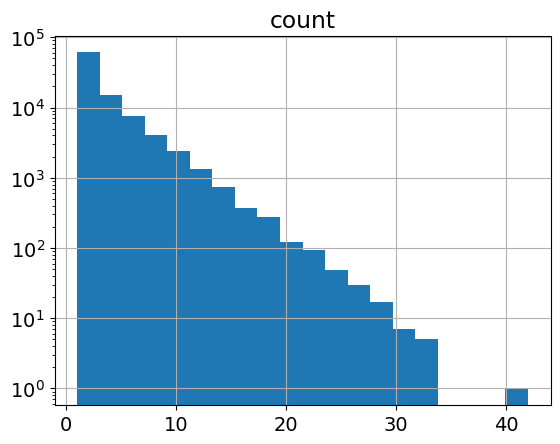

In [14]:
iarai_spd_outlier_cnt = irari_spd_outlier.groupby(['s', 'e']).size().reset_index(name = 'count')
iarai_spd_outlier_cnt.hist('count', bins=20, log=True)

In [15]:
# Further check of the spatial distribution of the speed difference between median speed and free flow speed 
# is done in QGIS.
iarai_spd_outlier_cnt.to_csv(os.path.join(f'iarai_median_spd_lgr_freeflow-{check_date}.csv'))

<AxesSubplot: xlabel='free_flow_kph', ylabel='median_speed_kph'>

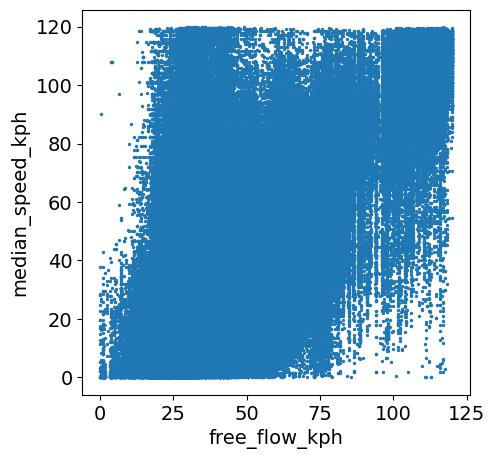

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
df_iarai.plot.scatter(x='free_flow_kph', y='median_speed_kph', ax=ax, s=2)

The speed difference between the median speed and free flow speed is consistent during the whole day, excluding the outliers.

In [17]:
df_iarai['spd_diff'] = df_iarai['median_speed_kph'] - df_iarai['free_flow_kph']

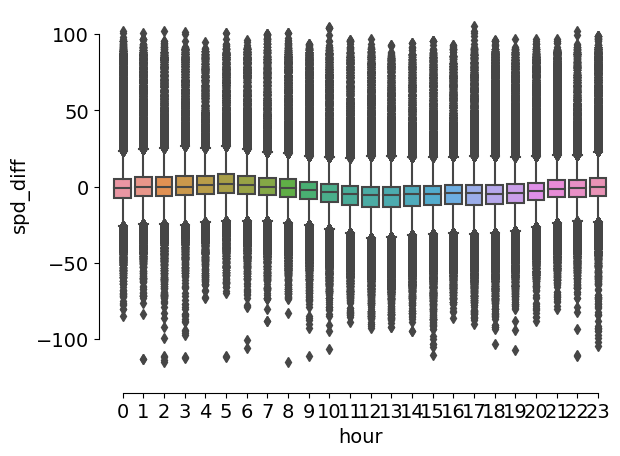

In [18]:
sns.boxplot(x="hour", y="spd_diff", data=df_iarai)
sns.despine(offset=10, trim=True)

In [19]:
iarai_seg_spd_diff = df_iarai.groupby(['s', 'e'])['spd_diff'].agg(['mean', 'median', 'std']).reset_index()

array([[<AxesSubplot: title={'center': 'mean'}>]], dtype=object)

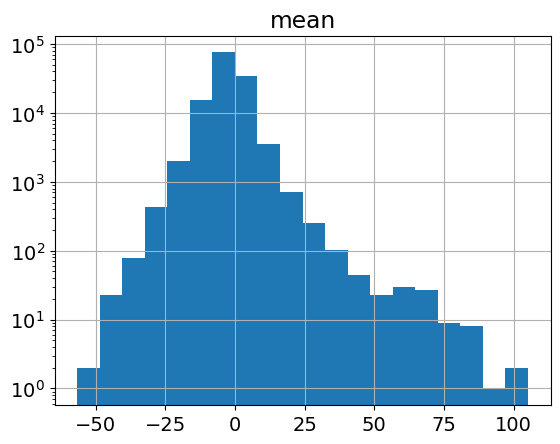

In [20]:
iarai_seg_spd_diff.hist('mean', bins=20, log=True)

## within-day IARIA median speed vs. Uber mean speed

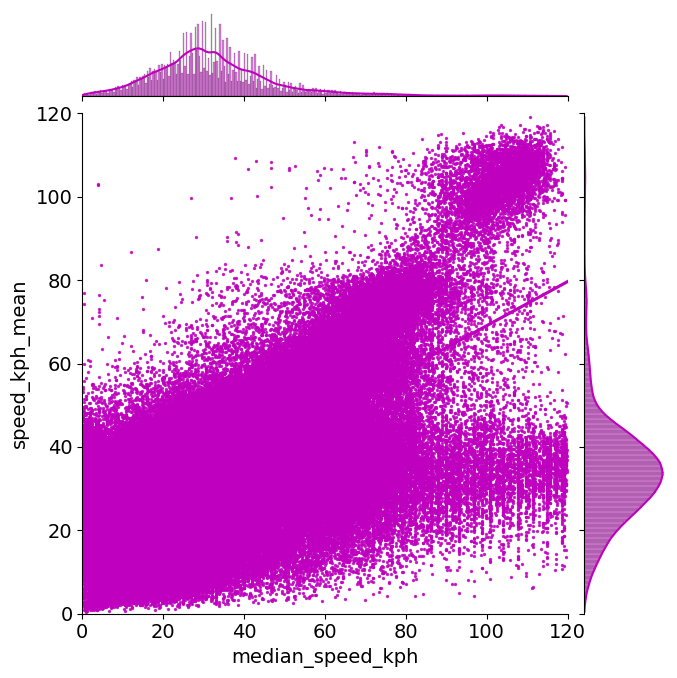

In [21]:
g = sns.jointplot(x="median_speed_kph", y="speed_kph_mean", data=df_agg_join,
                  kind="reg", truncate=False,
                  xlim=(0, 120), ylim=(0, 120),
                  color="m", height=7, scatter_kws={"s": 2})

In [22]:
sp.stats.pearsonr(df_agg_join.median_speed_kph, df_agg_join.speed_kph_mean)

PearsonRResult(statistic=0.6754266728250111, pvalue=0.0)

The speed difference between the median speed and Uber's mean speed is consistent during the whole day, excluding the outliers.

In [23]:
df_agg_join['median_uber_diff'] = df_agg_join['median_speed_kph'] - df_agg_join['speed_kph_mean']

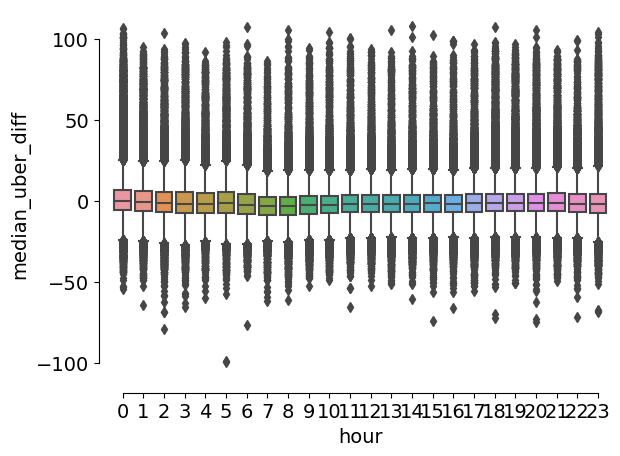

In [24]:
sns.boxplot(x="hour", y="median_uber_diff",
            #hue="smoker", palette=["m", "g"],
            data=df_agg_join)
sns.despine(offset=10, trim=True)

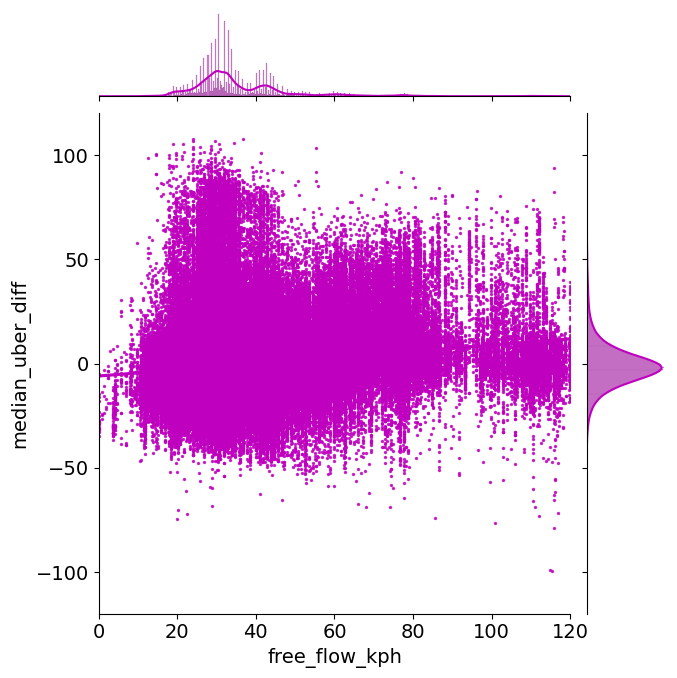

In [25]:
g = sns.jointplot(x="free_flow_kph", y="median_uber_diff", data=df_agg_join,
                  kind="reg", truncate=False,
                  xlim=(0, 120), ylim=(-120, 120),
                  color="m", height=7, scatter_kws={"s": 2})

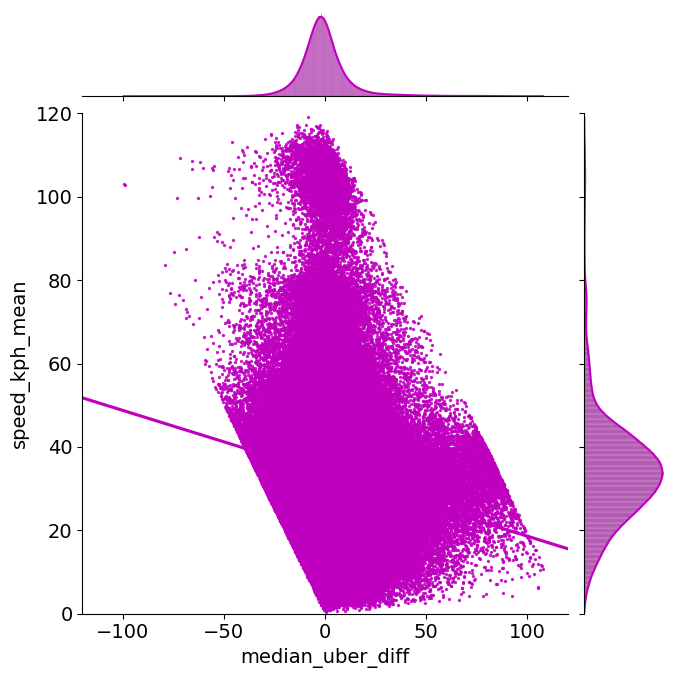

In [26]:
g = sns.jointplot(x="median_uber_diff", y="speed_kph_mean", data=df_agg_join,
                  kind="reg", truncate=False,
                  xlim=(-120, 120), ylim=(0, 120),
                  color="m", height=7, scatter_kws={"s": 2})

The temporal profile of IARAI segments is diffrent from Uber. Uber has two peaks of a day, most likely due to the commuting while IARAI's fleet has a flat distribution during the day with a decline around 16:00. 

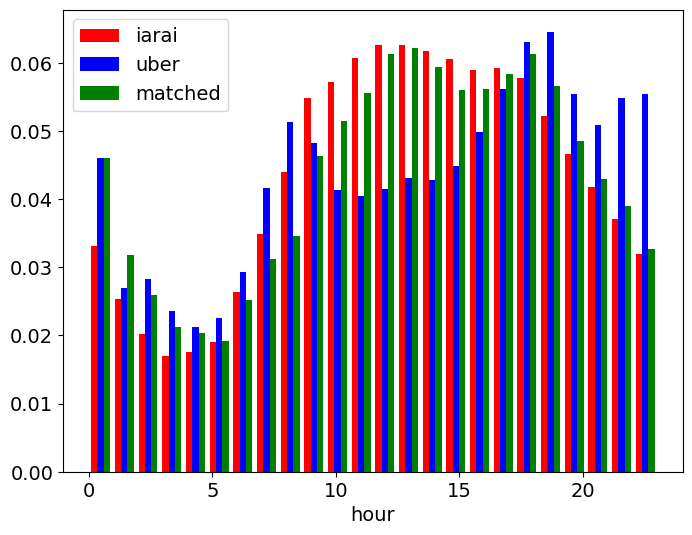

In [27]:
colors = ['red', 'blue', 'green']
fig, ax = plt.subplots(figsize=(8,6))

ax.hist([df_iarai.groupby(['s', 'e', 'hour']).size().reset_index().hour, df_uber.hour, df_agg_join.hour], 
            bins=24, density=True, histtype='bar', 
            color=colors, label=['iarai', 'uber', 'matched'])
ax.set_xlabel('hour')
plt.legend()

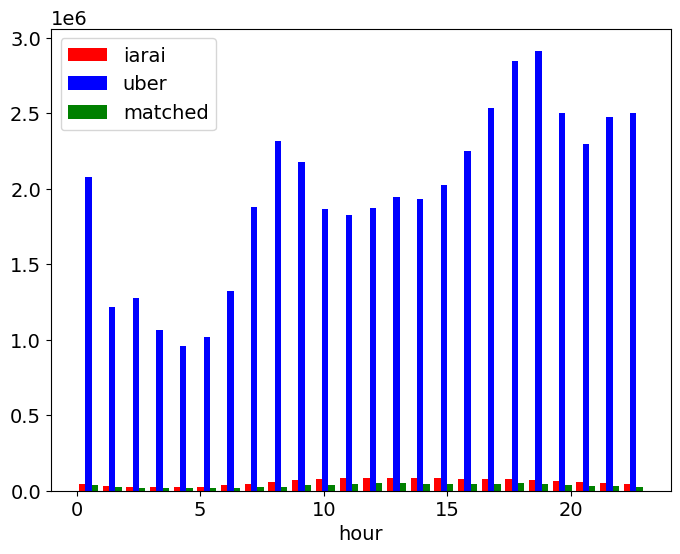

In [28]:
colors = ['red', 'blue', 'green']
fig, ax = plt.subplots(figsize=(8,6))

ax.hist([df_iarai.groupby(['s', 'e', 'hour']).size().reset_index().hour, df_uber.hour, df_agg_join.hour], 
        bins=24, density=False, histtype='bar', 
            color=colors, label=['iarai', 'uber', 'matched'])
ax.set_xlabel('hour')
plt.legend()

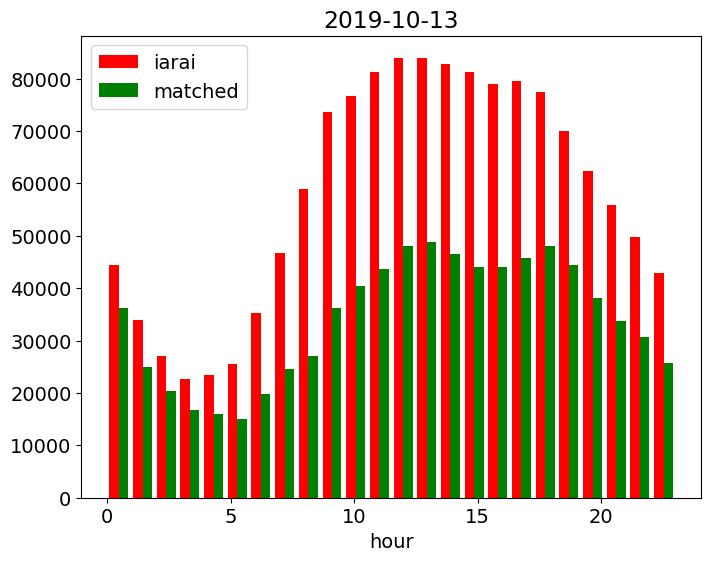

In [29]:
colors = ['red', 'green']
fig, ax = plt.subplots(figsize=(8,6))

ax.hist([df_iarai.groupby(['s', 'e', 'hour']).size().reset_index().hour, df_agg_join.hour], 
        bins=24, density=False, histtype='bar', 
            color=colors, label=['iarai', 'matched'])
ax.set_xlabel('hour')
plt.title(f'{check_date}')
plt.legend()

### In terms of MSE, MAE, and RMSE

In [30]:
def mean_squared_error(array):
    return np.mean(array ** 2)

def mean_absolute_error(array):
    return np.mean(np.abs(array))

def rooted_mean_squared_error(array):
    return np.sqrt(mean_squared_error(array))

In [31]:
hourly_acc_metrics = df_agg_join.groupby(['hour'])['median_uber_diff'].agg([mean_squared_error,
                        mean_absolute_error, 
                        rooted_mean_squared_error]).reset_index()

Hourly rmse and mae do not look so high. We probably need to jusitify the rmse and mae values are acceptable.

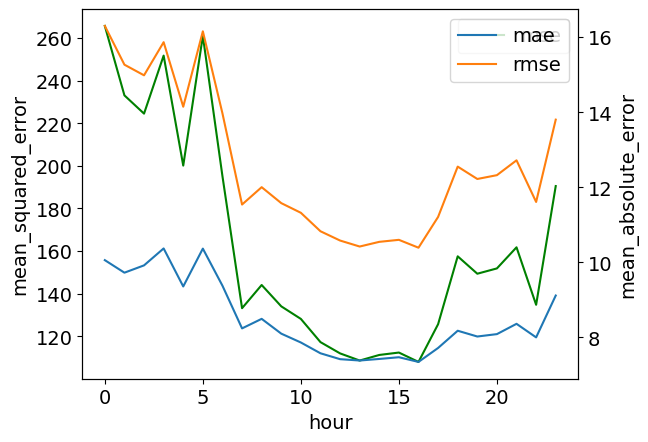

In [32]:
fig, ax = plt.subplots()

sns.lineplot(data=hourly_acc_metrics, x="hour", y="mean_squared_error", ax=ax, label='mse', color='green')

ax2 = ax.twinx()
sns.lineplot(data=hourly_acc_metrics, x="hour", y="mean_absolute_error", ax=ax2, label='mae')
sns.lineplot(data=hourly_acc_metrics, x="hour", y="rooted_mean_squared_error", ax=ax2, label='rmse')

ax2.legend()

In [33]:
day_time = range(8, 21)
night_time = [i for i in range(24) if i not in day_time]

In [34]:
print(sp.stats.ttest_ind(hourly_acc_metrics[hourly_acc_metrics.hour.isin(day_time)]['mean_squared_error'], 
                    hourly_acc_metrics[hourly_acc_metrics.hour.isin(night_time)][ 'mean_squared_error']))

print(sp.stats.ttest_ind(hourly_acc_metrics[hourly_acc_metrics.hour.isin(day_time)]['mean_absolute_error'], 
                    hourly_acc_metrics[hourly_acc_metrics.hour.isin(night_time)][ 'mean_absolute_error']))

print(sp.stats.ttest_ind(hourly_acc_metrics[hourly_acc_metrics.hour.isin(day_time)]['rooted_mean_squared_error'], 
                    hourly_acc_metrics[hourly_acc_metrics.hour.isin(night_time)][ 'rooted_mean_squared_error']))

Ttest_indResult(statistic=-5.431466163449527, pvalue=1.8656516971561577e-05)
Ttest_indResult(statistic=-6.0899915038170676, pvalue=3.952749946295703e-06)
Ttest_indResult(statistic=-5.57945320838076, pvalue=1.3114013084369141e-05)


## Are segments with high difference in median speed and free flow speed the same as those with high difference in median speed and Uber mean speed?

In [35]:
df_agg_join['median_freeflow_diff'] = df_agg_join['median_speed_kph'] - df_agg_join['free_flow_kph']
df_agg_join['abs_median_freeflow_diff'] = df_agg_join['median_freeflow_diff'].abs()
df_agg_join['abs_median_uber_diff'] = df_agg_join['median_uber_diff'].abs()

It seems true that if there is also a big difference between the median speed and the freeflow speed, there is big difference between the median speed and Uber's mean speed. 

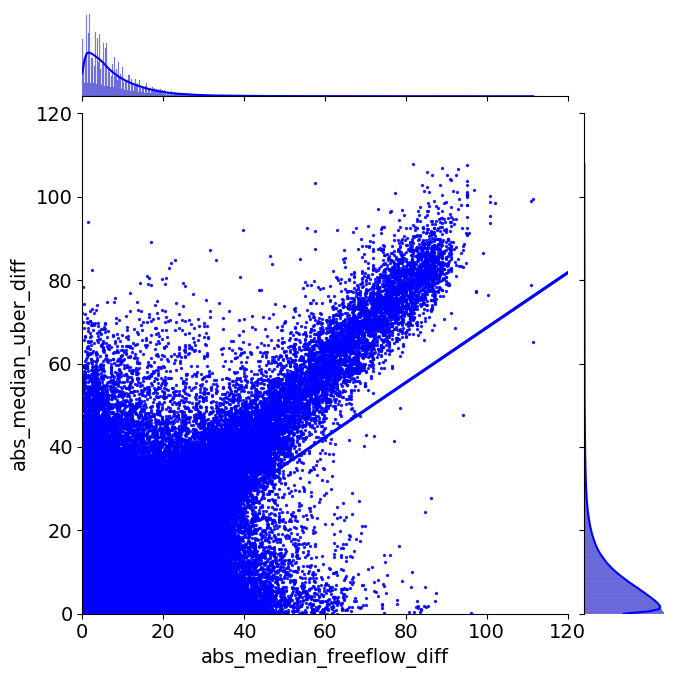

In [36]:
g = sns.jointplot(x="abs_median_freeflow_diff", y="abs_median_uber_diff", data=df_agg_join,
                  kind="reg", truncate=False,
                  xlim=(0, 120), ylim=(0, 120),
                  color="b", height=7, scatter_kws={"s": 2})

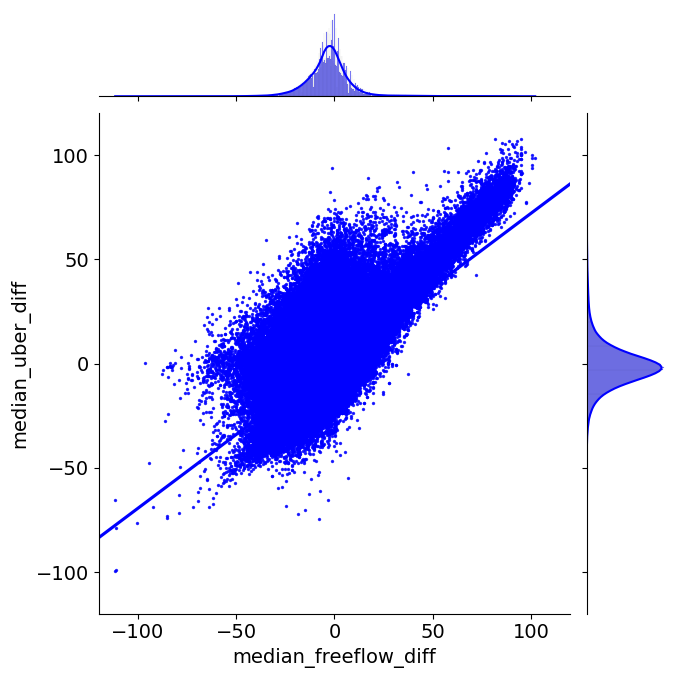

In [37]:
g = sns.jointplot(x="median_freeflow_diff", y="median_uber_diff", data=df_agg_join,
                  kind="reg", truncate=False,
                  xlim=(-120, 120), ylim=(-120, 120),
                  color="b", height=7, scatter_kws={"s": 2})